In [1]:
!pip install gdown

In [2]:
import gdown
import shutil

# shutil.os.mkdir('/kaggle/working/dataset')

url = 'https://drive.google.com/uc?export=download&id=1GlA5NQMSImR51HSfXjylQVF_aKZbaRrO'
output='/kaggle/working/data.zip'

gdown.download(url, output, quiet=False)
gdown.extractall(output, '/kaggle/working/dataset')
shutil.os.remove(output)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1GlA5NQMSImR51HSfXjylQVF_aKZbaRrO
From (redirected): https://drive.google.com/uc?export=download&id=1GlA5NQMSImR51HSfXjylQVF_aKZbaRrO&confirm=t&uuid=602719f8-3d19-4ab7-8e5b-d35169d0ff6a
To: /kaggle/working/data.zip
100%|██████████| 339M/339M [00:03<00:00, 102MB/s]  


# Import Packages

In [22]:
# inbuilt packages 
import os 
from PIL import Image
from tqdm import tqdm 

# Datascience Packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

# PyTorch Related Packages 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import models

# Hyper-parameters

In [23]:
batch_size = 16
model_input_size = 224
n_epoch = 5
learning_rate = 0.0001

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataloader

In [25]:
class FacialKeyPoints(Dataset):
    def __init__(self,csv_path,split='training',device=device):
        super(FacialKeyPoints).__init__()
        self.csv_path = csv_path
        self.split = split
        self.df = pd.read_csv(self.csv_path)
        self.device = device
        self.normalize = transforms.Normalize(
            mean = [0.485,0.456,0.406],
            std = [0.229,0.224,0.225]
        )
        
    def __len__(self):
        return len(self.df)        
    
    def __getitem__(self,index):
        img,original_size = self.get_image(index)
        keypoints = self.get_keypoints(index,original_size=original_size)
        return img,keypoints
    
    def get_image(self,index):
        image_path = os.path.join(os.getcwd(), 'dataset', self.split, self.df.iloc[index,0])
        img = Image.open(image_path).convert('RGB')
        original_size = img.size
        
        #image preprocessing
        img = img.resize((model_input_size,model_input_size))
        img = np.asarray(img,dtype=np.float32) / 255.0
        img = torch.tensor(img).permute(2,0,1).float()
        img = self.normalize(img)
        return img.to(self.device),original_size
        
    def get_keypoints(self,index,original_size):
        kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32)
        kp_x = kp[0::2] / original_size[0]
        kp_y = kp[1::2] / original_size[1]
        kp = np.concatenate([kp_x,kp_y])
        return torch.tensor(kp, dtype=torch.float32).to(self.device)
        
    def load_image(self,index):
        image_path = os.path.join(os.getcwd(), 'dataset', self.split, self.df.iloc[index,0])
        img = Image.open(image_path).convert('RGB')
        img = img.resize((model_input_size,model_input_size))
        return(np.asarray(img) / 255.0)

training_csv_path = '/kaggle/working/dataset/training_frames_keypoints.csv'
test_csv_path='/kaggle/working/dataset/test_frames_keypoints.csv'

training_data = FacialKeyPoints(training_csv_path,device=device)
test_data = FacialKeyPoints(test_csv_path, split='test', device=device)

In [26]:
training_dataloader = DataLoader(training_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [27]:
batch_img, batch_key_points = next(iter(training_dataloader))
batch_img.shape

torch.Size([16, 3, 224, 224])

In [28]:
batch_key_points.shape

torch.Size([16, 136])

# Dataset Visualization

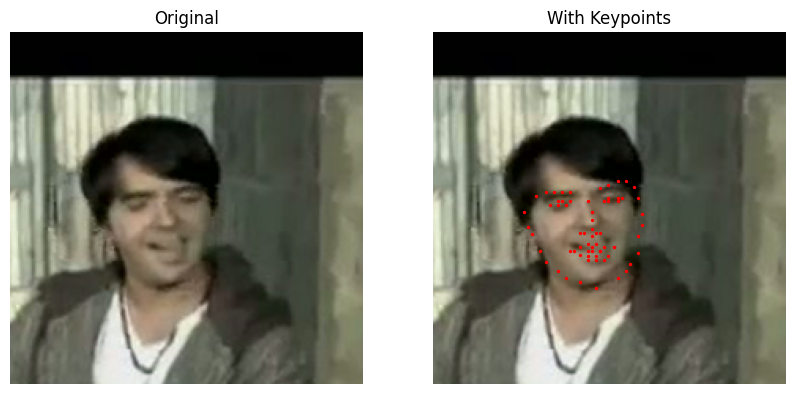

In [29]:
img_index = 0
img = training_data.load_image(img_index)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(img)


plt.subplot(122)
plt.title('With Keypoints')
plt.axis('off')
plt.imshow(img)

img_tensor, keypoints = training_data[img_index]
keypoints = keypoints.to('cpu')
plt.scatter(keypoints[:68] * model_input_size, keypoints[68:] * model_input_size, c='r',s = 2)

# Model Building

In [30]:
def get_model(device):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for layers in model.parameters():
        layers.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, 3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 136),
        nn.Sigmoid()
    )
    return model.to(device=device)
model = get_model(device=device)

In [35]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [36]:
def training_batch(imgs, keypoints, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    # forward Pass
    keypoints_pred = model(imgs)
    loss = criterion(keypoints_pred, keypoints)

    # backward Pass
    loss.backward()
    optimizer.step()

    return loss 

In [37]:
@torch.no_grad()
def validation_batch(imgs, keypoints, model, criterion):
    model.eval()

    keypoints_pred = model(imgs)
    loss = criterion(keypoints_pred, keypoints)
    return loss

# Training Pipeline

In [38]:
training_loss = []
test_loss = []

for epoch in range(1, n_epoch+1):
    epoch_training_loss, epoch_test_loss = 0, 0 

    # training 
    for images, keypoints in tqdm(training_dataloader, desc=f'Training {epoch} of {n_epoch}'): 
        loss = training_batch(images, keypoints, model, criterion, optimizer)
        epoch_training_loss+= loss.item()
    epoch_training_loss /= len(training_dataloader)
    training_loss.append(epoch_training_loss)
   
    # validation
    for images, keypoints in tqdm(test_dataloader, desc="validation"):
        loss = validation_batch(images, keypoints, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_dataloader)
    test_loss.append(epoch_test_loss)

    print(f"Epoch {epoch} of {n_epoch}: Training Loss: {epoch_training_loss}, Test Loss: {epoch_test_loss}")

validation: 100%|██████████| 49/49 [00:07<00:00,  6.63it/s]


Epoch 1 of 5: Training Loss: 0.004074427367333958, Test Loss: 0.0012319462245558293


validation: 100%|██████████| 49/49 [00:07<00:00,  6.64it/s]


Epoch 2 of 5: Training Loss: 0.0018818153707902826, Test Loss: 0.0008408425314047811


validation: 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]


Epoch 3 of 5: Training Loss: 0.001355534168614787, Test Loss: 0.0007302093020241175


validation: 100%|██████████| 49/49 [00:07<00:00,  6.67it/s]


Epoch 4 of 5: Training Loss: 0.0011122545218288315, Test Loss: 0.0006725881991157195


validation: 100%|██████████| 49/49 [00:07<00:00,  6.66it/s]

Epoch 5 of 5: Training Loss: 0.0009843925347289902, Test Loss: 0.0005864731406754985


# Performance Curves

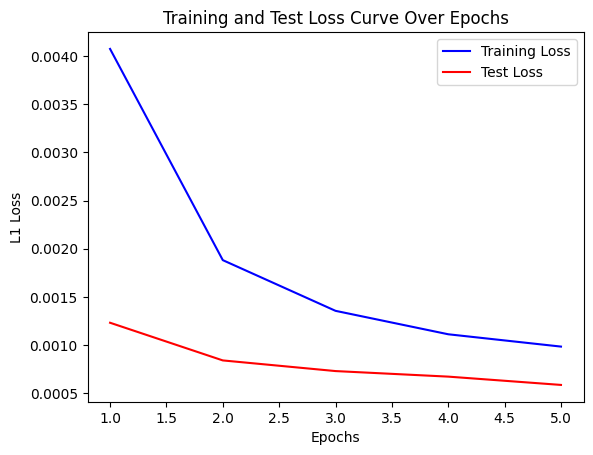

In [39]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title("Training and Test Loss Curve Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.show()

# Result Visualization

In [40]:
import gdown

url = 'https://drive.google.com/uc?export=download&id=1Nlt7PV3LKABSVNQNQQvcP8qXLDJQd9Or'
output = '/kaggle/working/myimage.jpg'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1Nlt7PV3LKABSVNQNQQvcP8qXLDJQd9Or
To: /kaggle/working/myimage.jpg
100%|██████████| 41.5k/41.5k [00:00<00:00, 31.6MB/s]


'/kaggle/working/myimage.jpg'

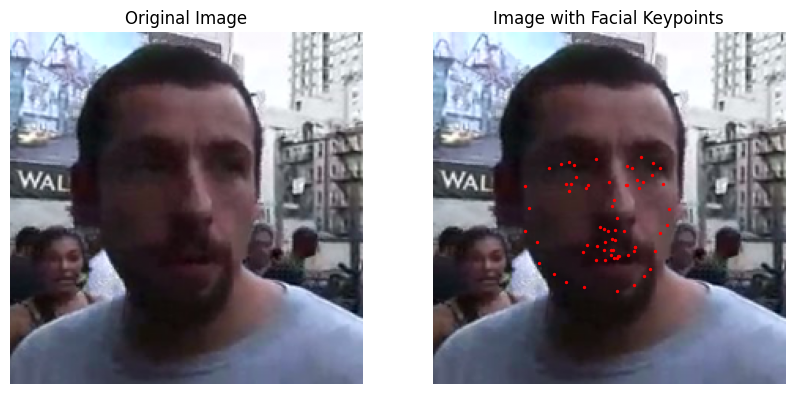

In [44]:
img_index = 11
img = test_data.load_image(img_index)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.axis('off')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.axis('off')
plt.imshow(img)

img, _ = test_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * model_input_size, kp_s[68:] * model_input_size, c='r',s = 2)